In [122]:
import pandas as pd
covid_data = pd.read_csv('../data/covid_data.csv')
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
import seaborn as sns
import plotly
import plotly.express as px

In [123]:
vaccinations_data = pd.read_csv('../data/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]

In [124]:
covid_data = covid_data.groupby(
    ['date', 'country'], 
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum()

covid_data['date'] = pd.to_datetime(covid_data['date'])

covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()

In [125]:
vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])

In [126]:
covid_df = covid_data.merge(
    vaccinations_data,
    on=('date', 'country'),
    how='left'
)

In [127]:
covid_df['death_rate'] = (covid_df['deaths'] / covid_df['confirmed'])*100
covid_df['recover_rate'] = (covid_df['recovered'] / covid_df['confirmed'])*100

In [128]:
u = covid_df.groupby('country')['recover_rate'].mean()
u['Russia']

67.06273489477655

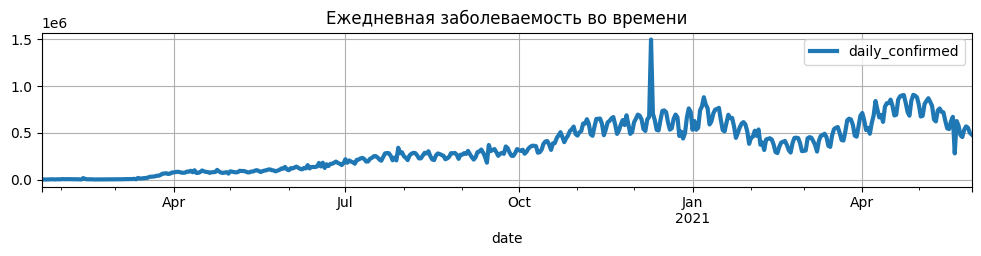

In [129]:
grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind='line',
    figsize=(12, 2),
    title='Ежедневная заболеваемость во времени',
    grid = True,
    legend=True,
    lw=3
);

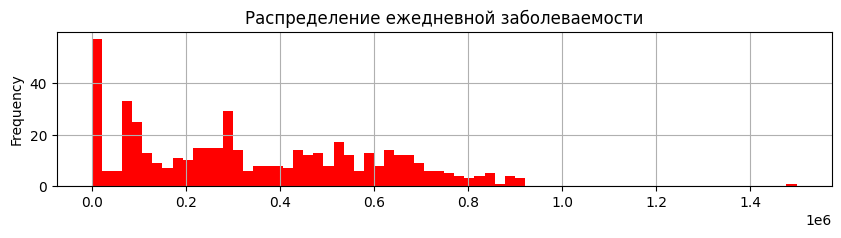

In [130]:
grouped_cases.plot(
    kind='hist',
    figsize=(10, 2),
    title='Распределение ежедневной заболеваемости',
    grid = True,
    color = 'red',
    bins=70
);

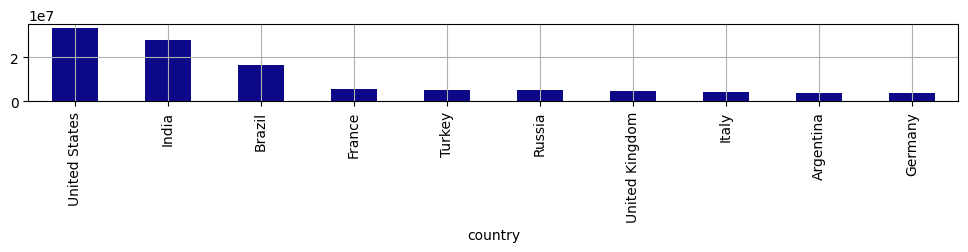

In [131]:
grouped_country = covid_df.groupby(['country'])['confirmed'].last()
grouped_country = grouped_country.nlargest(10)
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 1),
    colormap='plasma'
);

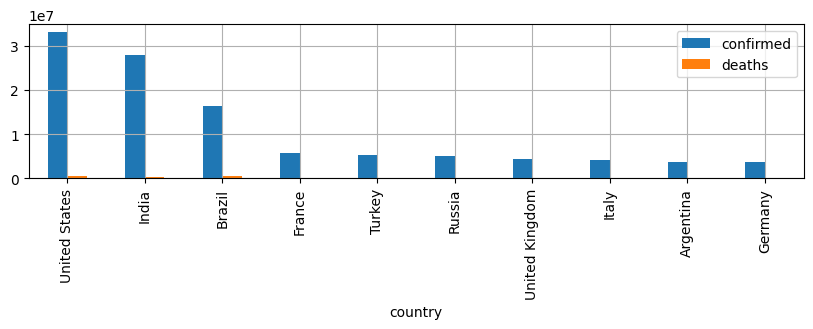

In [132]:
grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['confirmed'])
grouped_country.plot(     kind='bar',     grid=True,     figsize=(10, 2), );

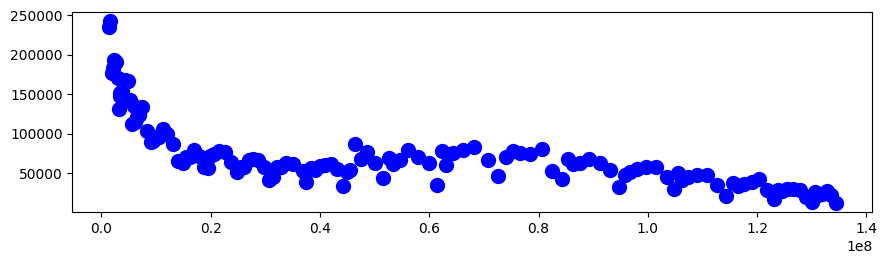

In [133]:
us_data = covid_df[covid_df['country'] == 'United States']

axes = plt.figure(figsize=(8, 2)).add_axes([0, 0, 1, 1])
axes.scatter(
    x=us_data['people_fully_vaccinated'], 
    y=us_data['daily_confirmed'], 
    s=100,
    marker='o',
    c = 'blue'
);

In [134]:
combination_not_nan = covid_df.dropna(subset=['vaccines'])
combination_last = combination_not_nan.groupby(['country'])['vaccines'].last()
combination_last = combination_last.apply(lambda x: x.replace(' ', '').split(','))
vaccines_dict = {} 
for vaccines_list in combination_last:
    for vaccine in vaccines_list:
        if vaccine not in vaccines_dict:
            vaccines_dict[vaccine] = 1 
        else:
            vaccines_dict[vaccine] += 1
vaccines = pd.Series(vaccines_dict).sort_values(ascending=False)
vaccines['other'] = vaccines[7:].sum()
vaccines = vaccines.sort_values(ascending=False)[:8]

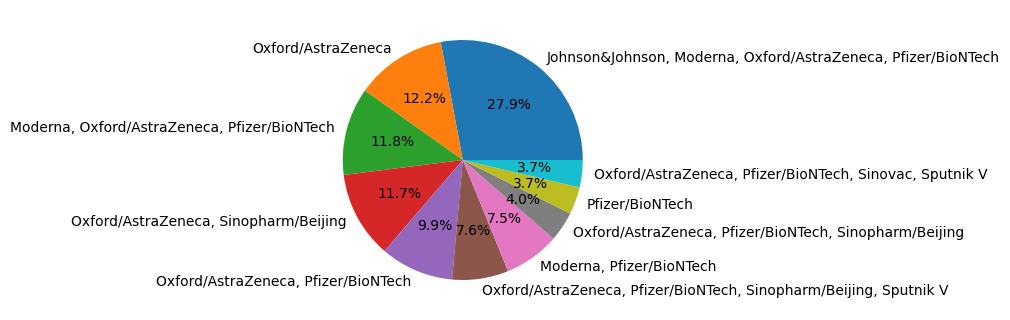

In [135]:
vaccine_combinations = covid_df['vaccines'].value_counts()[:10]
axes = plt.figure(figsize=(3, 3)).add_axes([0, 0, 1, 1])
axes.pie(
    vaccine_combinations,
    labels=vaccine_combinations.index,
    autopct='%.1f%%',
    explode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
);

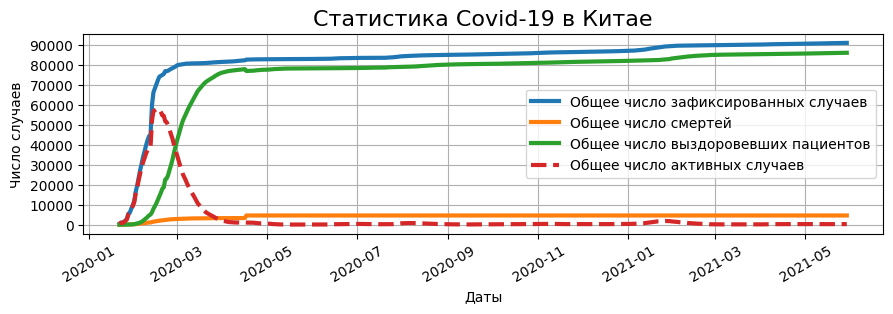

In [136]:
china_data = covid_df[covid_df['country'] == 'China']
china_grouped = china_data.groupby(['date'])[['confirmed', 'active', 'deaths', 'recovered']].sum()

#визуализация графиков
fig = plt.figure(figsize=(8, 2))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(china_grouped['confirmed'], label='Общее число зафиксированных случаев', lw=3)
axes.plot(china_grouped['deaths'], label='Общее число смертей', lw=3)
axes.plot(china_grouped['recovered'], label='Общее число выздоровевших пациентов', lw=3)
axes.plot(china_grouped['active'], label='Общее число активных случаев', lw=3, linestyle='dashed')

#установка параметров отображения
axes.set_title('Статистика Covid-19 в Китае', fontsize=16)
axes.set_xlabel('Даты')
axes.set_ylabel('Число случаев')
axes.set_yticks(range(0, 100000, 10000))
axes.xaxis.set_tick_params(rotation=30)
axes.grid()
axes.legend();

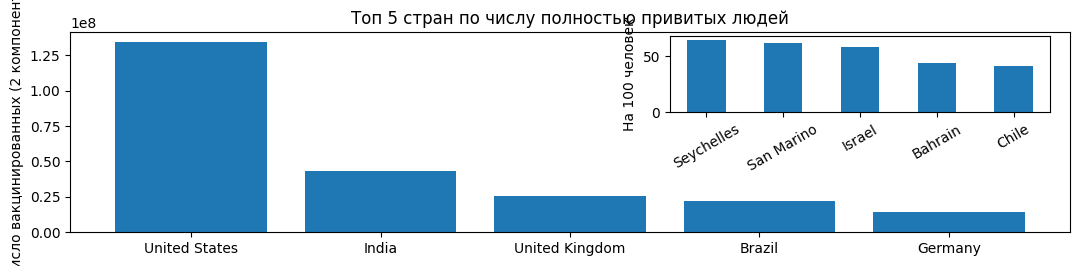

In [137]:
vacc_country = covid_df.groupby('country')['people_fully_vaccinated'].last().nlargest(5)
vacc_country_per_hundred = covid_df.groupby('country')['people_fully_vaccinated_per_hundred'].last().nlargest(5)

#визуализация главного графика
fig = plt.figure(figsize=(10, 2))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = vacc_country.index, height = vacc_country);
main_axes.set_ylabel('Число вакцинированных (2 компонент)')
main_axes.set_title('Топ 5 стран по числу полностью привитых людей')

#визуализация вспомогательного графика
insert_axes = fig.add_axes([0.6, 0.6, 0.38, 0.38])
insert_axes.bar(x = vacc_country_per_hundred.index, height = vacc_country_per_hundred, width=0.5);
insert_axes.set_ylabel('На 100 человек')
insert_axes.xaxis.set_tick_params(rotation=30)

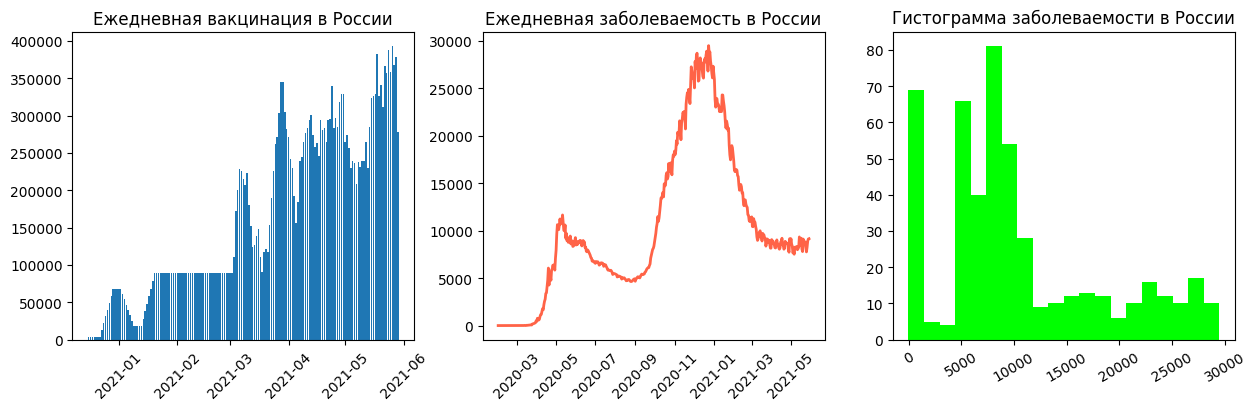

In [138]:
russia_data = covid_df[covid_df["country"] == "Russia"]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

axes[0].bar(
    x=russia_data["date"],
    height=russia_data["daily_vaccinations"],
    label="Число вакцинированных",
)
axes[0].set_title("Ежедневная вакцинация в России")
axes[0].xaxis.set_tick_params(rotation=45)

axes[1].plot(
    russia_data["date"],
    russia_data["daily_confirmed"],
    label="Число заболевших",
    color="tomato",
    lw=2,
)
axes[1].set_title("Ежедневная заболеваемость в России")
axes[1].xaxis.set_tick_params(rotation=45)

axes[2].hist(
    x=russia_data["daily_confirmed"], label=["Число заболевших"], color="lime", bins=20
)
axes[2].set_title("Гистограмма заболеваемости в России")
axes[2].xaxis.set_tick_params(rotation=30)


In [139]:
countries = ['Russia', 'Australia', 'Germany', 'Canada', 'United Kingdom']
croped_covid_df = covid_df[covid_df['country'].isin(countries)]

populations = pd.DataFrame([
    ['Canada', 37664517],
    ['Germany', 83721496],
    ['Russia', 145975300],
    ['Australia', 25726900],
    ['United Kingdom', 67802690]
    ],
    columns=['country', 'population']
)
croped_covid_df = croped_covid_df.merge(populations, on=['country'])
croped_covid_df['daily_confirmed_per_hundred'] = croped_covid_df['daily_confirmed'] / croped_covid_df['population'] * 100


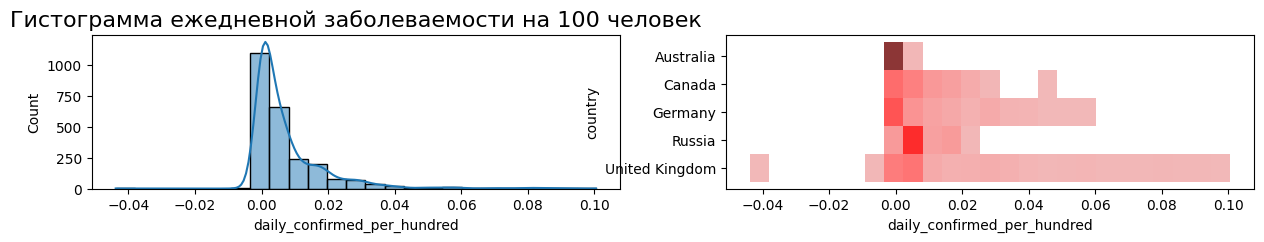

In [140]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 2))
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    bins=25,
    kde=True,
    ax=axes[0]
);
axes[0].set_title('Гистограмма ежедневной заболеваемости на 100 человек', fontsize=16)
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    y='country',
    bins=25,
    color='red',
    ax=axes[1]
);

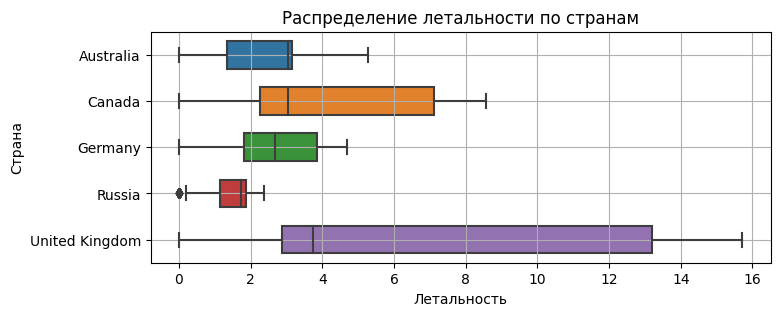

In [141]:
fig = plt.figure(figsize=(8, 3))
boxplot = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='death_rate',
    orient='h',
    width=0.6
)
boxplot.set_title('Распределение летальности по странам');
boxplot.set_xlabel('Летальность');
boxplot.set_ylabel('Страна');
boxplot.grid()

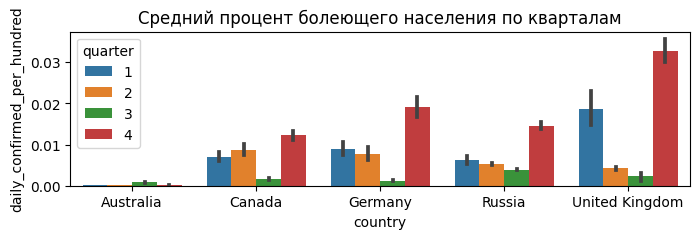

In [142]:
fig = plt.figure(figsize=(8, 2))
croped_covid_df['quarter'] = croped_covid_df['date'].dt.quarter
barplot = sns.barplot(
    data=croped_covid_df,
    x='country',
    y='daily_confirmed_per_hundred',
    hue='quarter',
)
barplot.set_title('Средний процент болеющего населения по кварталам');

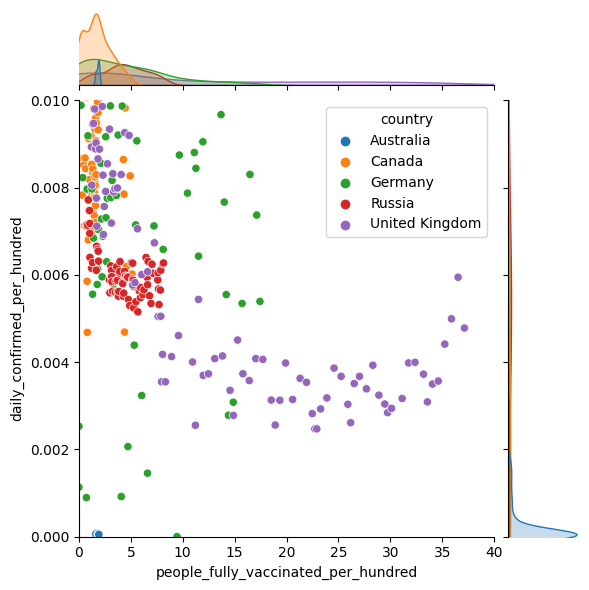

In [143]:
jointplot = sns.jointplot(
    data=croped_covid_df, 
    x='people_fully_vaccinated_per_hundred', 
    y='daily_confirmed_per_hundred',
    hue='country',
    xlim = (0, 40),
    ylim = (0, 0.01),
    height=6
);

In [144]:
pivot = croped_covid_df.pivot_table(
    values='people_vaccinated_per_hundred',
    columns='date',
    index='country',
)
pivot.columns = pivot.columns.astype('string')

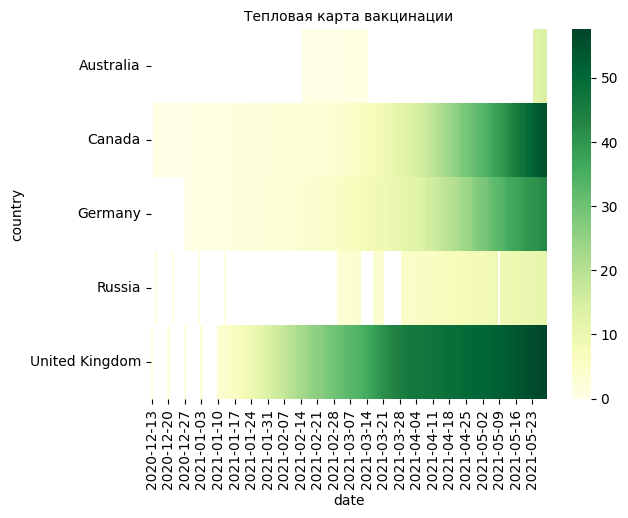

In [145]:
heatmap = sns.heatmap(data=pivot, cmap='YlGn')
heatmap.set_title('Тепловая карта вакцинации', fontsize=10);

In [146]:
croped_covid_df['confirmed_per_hundred'] = (croped_covid_df['confirmed']/ croped_covid_df['population'])/100
con = croped_covid_df.pivot_table(
    values='confirmed_per_hundred',
    columns='date',
    index='country',
)
pivot.columns = pivot.columns.astype('string')

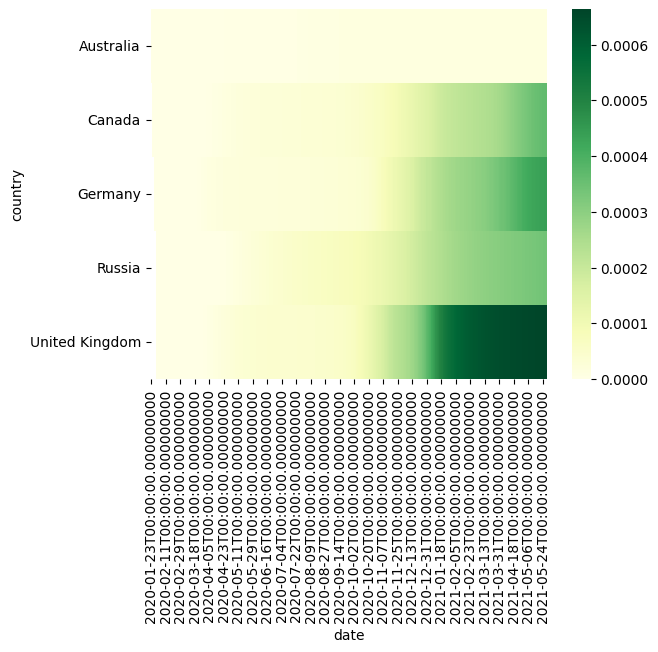

In [147]:
hm = sns.heatmap(data = con, cmap = 'YlGn')

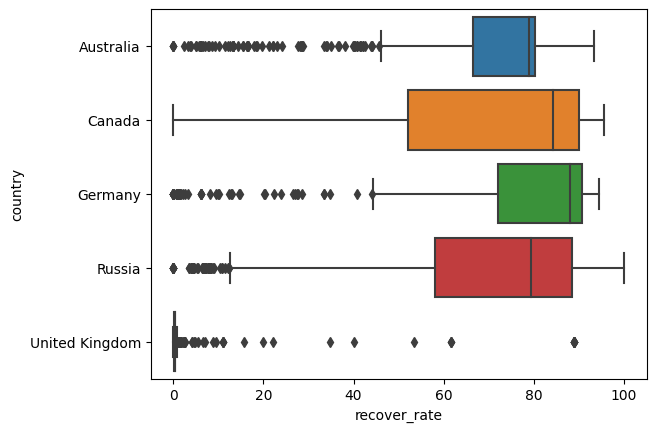

In [148]:
box = sns.boxplot(croped_covid_df, y = 'country', x = 'recover_rate');

In [153]:
line_data = covid_df.groupby('date', as_index=False).sum()
fig = px.line(
    data_frame=line_data, #DataFrame
    x='date', #ось абсцисс
    y=['confirmed', 'recovered', 'deaths', 'active'], #ось ординат
    height=300, #высота
    width=600, #ширина
    title='Confirmed, Recovered, Deaths, Active cases over Time' #заголовок
)
fig.show()

In [154]:
#считаем средний процент выздоровлений для каждой страны
bar_data = covid_df.groupby(
    by='country',
    as_index=False
)[['recover_rate']].mean().round(2).nlargest(10, columns=['recover_rate'])

#строим график
fig = px.bar(
    data_frame=bar_data, #датафрейм
    x="country", #ось x
    y="recover_rate", #ось y
    color='country', #расцветка в зависимости от страны
    text = 'recover_rate', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Top 10 Countries for Recovery Rate' #заголовок
)

#отображаем его
fig.show()

In [157]:
treemap_data = covid_df.groupby(
    by='country',
    as_index=False
)[['daily_recovered']].mean()

#строим график
fig = px.treemap(
    data_frame=treemap_data, #DataFrame
    path=['country'], #категориальный признак, для которого строится график
    values='daily_recovered', #параметр, который сравнивается
    height=400, #высота
    width=800, #ширина
    title='Daily Recovered Cases by Country' #заголовок
)

#отображаем график
fig.show()


In [160]:
choropleth_data = covid_df.sort_values(by='date')
choropleth_data['date'] = choropleth_data['date'].astype('string')

#строим график
fig = px.choropleth(
    data_frame=choropleth_data, #DataFrame
    locations="country", #столбец с локациями
    locationmode = "country names", #режим сопоставления локаций с базой Plotly
    color="confirmed", #от чего зависит цвет
    animation_frame="date", #анимационный бегунок
    range_color=[0, 30e6], #диапазон цвета
    title='Global Spread of COVID-19', #заголовок
    width=800, #ширина
    height=500, #высота
    color_continuous_scale='Reds' #палитра цветов
)

#отображаем график
fig.show()

In [164]:
countries=['United States', 'Russia', 'United Kingdom', 'Brazil', 'France']
scatter_data = covid_df[covid_df['country'].isin(countries)]

#строим график
fig = px.scatter_3d(
    data_frame=scatter_data, #DataFrame
    x = 'daily_confirmed', #ось абсцисс
    y = 'daily_deaths', #ось ординат
    z = 'daily_vaccinations', #ось аппликат
    color='country', #расцветка в зависимости от страны
    log_x=True, 
    log_y=True,
    width=800,
    height=500
)

#отображаем график
fig.show()

In [171]:
dayvac = covid_df.groupby('date', as_index=False)['daily_vaccinations'].sum()
fig = px.line(
    data_frame=dayvac, 
    x='date', 
    y='daily_vaccinations',
    height=300, 
    width=600, 
    title='Daily vaccinated'
)
fig.show()

In [174]:
fuu = covid_df.sort_values(by='date')
fuu['date'] = fuu['date'].astype('string')
fig = px.choropleth(
    data_frame=fuu,
    locations="country",
    locationmode = "country names",
    color="total_vaccinations",
    animation_frame="date",
    range_color=[0, 30e6], 
    title='ЗХПЛзщомслиал',
    width=800, 
    height=500, 
    color_continuous_scale='Reds' 
)

#отображаем график
fig.show()